In [152]:
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import os

from scipy.signal import medfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [154]:
test = False

# First Steps (1-5) is Template for Any Exercise

In [153]:
def split_num(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head, tail

def files_in_order(folderpath):
    npy_files = os.listdir(folderpath)

    no_extensions = [os.path.splitext(npy_file)[0] for npy_file in npy_files]

    splitted = [split_num(s) for s in no_extensions]

    splitted = np.array(splitted)

    indices = np.lexsort((splitted[:, 1].astype(int), splitted[:, 0]))

    npy_files = np.array(npy_files)
    return npy_files[indices]

# Generates binary labels (good=1, bad=0) given an array-like of filenames
def get_labels(array):
    labels = [1 if "good" in i else 0 for i in array]
    return np.array(labels)

### Step 1: Load files with coordinates of poses

In [155]:
files = files_in_order('poses_compressed/bicep')
#print(files)
if test:
    X_train_names, X_test_names = train_test_split(files, test_size=0.4, random_state=42)
    y_train = get_labels(X_train_names)
    y_test = get_labels(X_test_names)
else: 
    X_train_names = files
    y_train = get_labels(X_train_names)

#### Load from Input JSON file

get from instructions on README.md in detectron folder

In [157]:
def load_tester(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)
data = load_tester('/tmp/mountdir/video_output.json')

In [158]:
data[4]

{'nose': [361.98907470703125, 438.5970458984375],
 'left_eye': [292.9515075683594, 457.2869567871094],
 'right_eye': [297.2663879394531, 467.3507385253906],
 'left_ear': [308.7726135253906, 606.8059692382812],
 'right_ear': [310.2109069824219, 609.6813354492188],
 'left_shoulder': [507.2555236816406, 668.6263427734375],
 'right_shoulder': [524.5149536132812, 665.7509155273438],
 'left_elbow': [1081.1302490234375, 720.3829345703125],
 'right_elbow': [1075.376953125, 714.6322021484375],
 'left_wrist': [451.16253662109375, 628.3712158203125],
 'right_wrist': [468.42193603515625, 629.808837890625],
 'left_hip': [730.1892700195312, 821.020751953125],
 'right_hip': [792.035400390625, 818.1453857421875],
 'left_knee': [1082.5684814453125, 737.6351318359375],
 'right_knee': [1082.5684814453125, 711.7568359375],
 'left_ankle': [1084.0067138671875, 727.5713500976562],
 'right_ankle': [1085.4449462890625, 707.4437866210938],
 'neck': [515.8852386474609, 667.1886291503906],
 'hip': [761.1123352050

### Step 2: Create class for a Part (showing x and y coordinates for each part name)

In [159]:
class Part:
    def __init__(self, vals):
        self.x = vals[0]
        self.y = vals[1]
        if len(vals) > 2:
            self.c = vals[2]
            self.exists = self.c != 0.0
        else: 
            self.c = None
            self.exists = True

    def __floordiv__(self, scalar):
        __truediv__(self, scalar)

    def __truediv__(self, scalar):
        if self.c is not None: 
            return Part([self.x / scalar, self.y / scalar, self.c])
        return Part([self.x / scalar, self.y / scalar])#, self.c])

    @staticmethod
    def dist(part1, part2):
        return np.sqrt(np.square(part1.x - part2.x) + np.square(part1.y - part2.y))

### Step 3: For each video frame, encode parts for every part name

In [160]:
class Pose:
    
    # ********** Fix this part names array based on order of pose estimation coordinates ***********
    PART_NAMES = ['nose', 'neck',  'right_shoulder', 'right_elbow', 'right_wrist', 'left_shoulder', 'left_elbow', 'left_wrist', 'right_hip', 'right_knee', 'right_ankle', 'left_hip', 'left_knee', 'left_ankle', 'right_eye', 'left_eye', 'right_ear', 'left_ear']
    def __init__(self, parts):
        """Construct a pose for one frame, given an array of parts

        Arguments:
            parts - 18 * 3 ndarray of x, y, confidence values
        """
        if type(parts) == dict: 
            for name in self.PART_NAMES: 
                setattr(self, name, Part(parts[name]))
        else: 
            for name, vals in zip(self.PART_NAMES, parts):
                setattr(self, name, Part(vals))
    def __iter__(self):
        for attr, value in self.__dict__.items():
            yield attr, value
    def __str__(self):
        out = ""
        for name in self.PART_NAMES:
            _ = "{}: {},{}".format(name, getattr(self, name).x, getattr(self, name).y)
            out = out + _ +"\n"
        return out
    def print(self, parts):
        out = ""
        for name in parts:
            if not name in self.PART_NAMES:
                raise NameError(name)
            _ = "{}: {},{}".format(name, getattr(self, name).x, getattr(self, name).y)
            out = out + _ +"\n"
        return out

### Step 4: Time Series (Sequence) of Pose Estimations for every frame in a Video

In [161]:
class PoseSequence:
    """
    Chains pose estimations from each video frame
    """
    def __init__(self, sequence):
        self.poses = [] # sequence of poses where a pose is a coordinate for each part
        for parts in sequence:
            self.poses.append(Pose(parts))
        
        # normalize poses based on the average torso pixel length, from the article as described below: 
        """
        to generalize our application to account for users with different body length measurements, distance 
            from the camera, as well as other relative factors
        we normalize the pose based on
            the torso’s length in pixels. The torso length is calculated
            by the average of the distance from the neck keypoint to the
            right and left hip keypoints. This normalization works extremely well: we observe that the torso length stays very
            constant through all the frames of input videos. Distances
            are thus represented as ratios of torso length: for instance,
            an upper arm length of 0.6 means that the upper arm is 0.6
            the length of the torso.
        """
        torso_lengths = np.array([Part.dist(pose.neck, pose.left_hip) for pose in self.poses if pose.neck.exists and pose.left_hip.exists] +
                                 [Part.dist(pose.neck, pose.right_hip) for pose in self.poses if pose.neck.exists and pose.right_hip.exists])
        mean_torso = np.mean(torso_lengths)

        for pose in self.poses:
            for attr, part in pose:
                setattr(pose, attr, part / mean_torso) # the certain attribute of the pose should all be normalized

### Step 5: Load all KeyPoints from a given file

In [162]:
def load_ps(filename):
    """Load a PoseSequence object from a given numpy file.

    Args:
        filename: file name of the numpy file containing keypoints.
    
    Returns:
        PoseSequence object with normalized joint keypoints.
    """
    all_keypoints = np.load(filename) # has all the keypoints
    return PoseSequence(all_keypoints)

In [163]:
load_ps('poses_compressed/bicep/bicep_bad_10.npy').poses[0].left_shoulder.c

0.302079

#### From JSON file

In [164]:
input_seq = PoseSequence(data)

In [165]:
input_seq.poses[0].nose.x

0.8575401666453828

# Specifically for Bicep Curl (Change for other Exercises)

For other exercises: 
- Figure out important pose parts we need
- Get the difference in important poses to get lengths
- Figure out the important angles needed

What stays the same for all exercises
- normalization of vectors calculated (mentioned in fn below)
- median filtering (portion from article explains why its important)

### Step 6: For each video, calculate angles of upper arm torso and upper forearm angle - Bicep Curl Example ONLY

In [167]:
def load_features(names, data=None, side=None, bool_val=False):
    """
    Geometric interpretations
    Side --> encoded as left or right from user uploaded videos (without confidence encoded)
    """
    output1 = [] # List of upper arm torso angles
    output2 = [] # List of forearm upper arm angles

    for filename in names:
        if not bool_val: 
            ps = load_ps('poses_compressed/bicep/'+filename)
        else: 
            ps = PoseSequence(data)
        poses = ps.poses
        
        """
        For certain exercises, we resolve the ambiguity in camera perspective. For example, the bicep curl exercise is
            recorded from the side of the body, and could be performed
            with either the left or right arm. We identify which arm is
            performing the exercise in the video by measuring which
            keypoints are most visible (left or right side keypoints)
            throughout all frames of the exercise. This accurately detects perspective all of our input videos
        """
        if not bool_val: 
            right_present = [1 for pose in poses 
                    if pose.right_shoulder.exists and pose.right_elbow.exists and pose.right_wrist.exists] # check if right poses exist
            left_present = [1 for pose in poses
                    if pose.left_shoulder.exists and pose.left_elbow.exists and pose.left_wrist.exists] # check if left poses exist
            right_count = sum(right_present)
            left_count = sum(left_present)
            side = 'right' if right_count > left_count else 'left'
        
        if side == 'right':
            joints = [(pose.right_shoulder, pose.right_elbow, pose.right_wrist, pose.right_hip, pose.neck) for pose in poses]
        else:
            joints = [(pose.left_shoulder, pose.left_elbow, pose.left_wrist, pose.left_hip, pose.neck) for pose in poses]

        # filter out data points where a part does not exist
        joints = [joint for joint in joints if all(part.exists for part in joint)]
        
         # Shoulder to elbow (upper arm)
        upper_arm_vecs = np.array([(joint[0].x - joint[1].x, joint[0].y - joint[1].y) for joint in joints])
        # Neck to hip (torso)
        torso_vecs = np.array([(joint[4].x - joint[3].x, joint[4].y - joint[3].y) for joint in joints])
        # Elbow to wrist (forearm)
        forearm_vecs = np.array([(joint[2].x - joint[1].x, joint[2].y - joint[1].y) for joint in joints])
        
        # normalize portion: SAME FOR ALL EXERCISES
        upper_arm_vecs = upper_arm_vecs / np.expand_dims(np.linalg.norm(upper_arm_vecs, axis=1), axis=1)
        torso_vecs = torso_vecs / np.expand_dims(np.linalg.norm(torso_vecs, axis=1), axis=1)
        forearm_vecs = forearm_vecs / np.expand_dims(np.linalg.norm(forearm_vecs, axis=1), axis=1)
        
        # get all the angles and median filter them
        """
        A drawback with DTW is that it’s not robust to noise. When
            OpenPose generates noisy keypoints, this would affect the
            performance of DTW. To accommodate for this, we run the
            a keypoint sequence through a size 5 median filter twice before computing the DTW measures
        """
        upper_arm_torso_angle = np.degrees(np.arccos(np.clip(np.sum(np.multiply(upper_arm_vecs, torso_vecs), axis=1), -1.0, 1.0)))
        upper_arm_torso_angle_filtered = medfilt(medfilt(upper_arm_torso_angle, 5), 5) # size 5 median filter twice
        
        upper_arm_forearm_angle = np.degrees(np.arccos(np.clip(np.sum(np.multiply(upper_arm_vecs, forearm_vecs), axis=1), -1.0, 1.0)))
        upper_arm_forearm_angle_filtered = medfilt(medfilt(upper_arm_forearm_angle, 5), 5) # size 5 median filter twice

        output1.append(upper_arm_torso_angle_filtered.tolist())
        output2.append(upper_arm_forearm_angle_filtered.tolist())
    return output1, output2

X_train_1, X_train_2 = load_features(X_train_names)
if test:
    X_test_1, X_test_2 = load_features(X_test_names)
#features = load_features(files)

In [169]:
inp_seq_1, inp_seq_2 = load_features(['demo'], data, 'left', bool_val=True)

In [51]:
"""X_train_1.append(inp_seq_1[0])
X_train_2.append(inp_seq_2[0])
y_train = np.append(y_train, 1)"""

'X_train_1.append(inp_seq_1[0])\nX_train_2.append(inp_seq_2[0])\ny_train = np.append(y_train, 1)'

In [170]:
len(y_train)

16

In [181]:
len(inp_seq_1)

1

# KMeans used for any Exercise

### Step 7: Use KMeans Algorithm with DTWDistance

In [171]:
# Compute Dynamic Time Warp Distance of two sequences
# http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [172]:
def Kmeans_test(names, X_train_1, X_train_2, data=None, side=None, bool_val=False, n_neighbors=3): 
    if not bool_val:
        X_test_1, X_test_2 = load_features(names)
    else: 
        X_test_1, X_test_2 = load_features(names, data, side, bool_val=bool_val)
    predictions = []
    analysis = []
    for example in range(len(names)):
        # Store the average distance to good and bad training examples
        f1_good, f1_bad, f2_good, f2_bad = [[] for i in range(4)]

        # Compare distance of current test example with all training examples
        for i in range(len(X_train_1)):
            dist1 = DTWDistance(X_train_1[i], X_test_1[example])
            dist2 = DTWDistance(X_train_2[i], X_test_2[example])
            if y_train[i]:
                f1_good.append(dist1)
                f2_good.append(dist2)
            else:
                f1_bad.append(dist1)
                f2_bad.append(dist2)
                
        f1_good = np.array(f1_good)
        f2_bad = np.array(f2_bad)
        f2_good = np.array(f2_good)
        f1_bad = np.array(f1_bad)
                
        # sort good indices in first dimension
        good_idx_sort = np.argsort(f1_good)
        bad_idx_sort = np.argsort(f1_bad)
        
        f1_good = f1_good[good_idx_sort]
        f2_good = f2_good[good_idx_sort]
        f1_bad = f1_bad[bad_idx_sort]
        f2_bad = f2_bad[bad_idx_sort]
        
        plt.scatter(f1_good, f2_good, label='Distance to Good Form Ex.')
        plt.scatter(f1_bad, f2_bad, label='Distance to Bad Form Ex.')
        plt.xlabel("Distance using Upper Arm Torso Angle (in Degrees)")
        plt.ylabel("Distance using Upper Arm Forearm Angle (in Degrees)")
        plt.title(f"Distance between {names[example]} and Good/Bad Examples")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()
        
        good_score = np.mean(f1_good[:n_neighbors]) + np.mean(f2_good[:n_neighbors])
        bad_score = np.mean(f1_bad[:n_neighbors]) + np.mean(f2_bad[:n_neighbors])
        
        percentage = (good_score - bad_score) / bad_score * 100 * -1 # percentage
        
        if percentage > 0: 
            print(f"How good the form is in terms of percentage: {round(percentage, 2)}%")
        else: 
            print(f"How bad the form is in terms of percentage: {round(percentage, 2)}%")

        # if distance is closer to good form exercises
        if good_score < bad_score:
            predictions.append(1)
            analysis.append("Exercise Performed Correctly")
        else: # distance close to bad form exercises
            predictions.append(0)
            analysis.append("Exercise needs some work")
        print("-------------------------------------------------------------------------------------------------------------------")
    return analysis, predictions

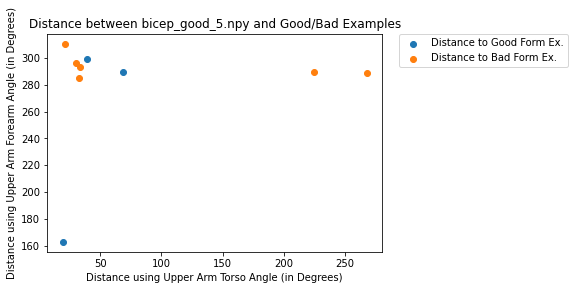

How good the form is in terms of percentage: 9.88%
-------------------------------------------------------------------------------------------------------------------


(['Exercise Performed Correctly'], [1])

In [131]:
# Test out with a given video (time series of pose estimations)
if test: 
    Kmeans_test([X_test_names[3]], X_train_1, X_train_2, n_neighbors=3)

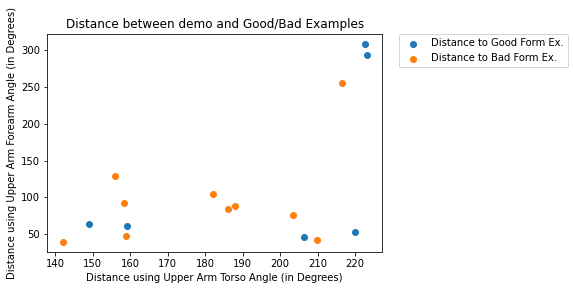

How good the form is in terms of percentage: 4.42%
-------------------------------------------------------------------------------------------------------------------


(['Exercise Performed Correctly'], [1])

In [173]:
# Test out with given input
Kmeans_test(['demo'], X_train_1, X_train_2, data, 'right', True, n_neighbors=3)

## Interpretation

The given scale for the numerical representation for each inputted video will range from -inf% -> inf%. The higher the positive value of the percentage, the better the form of the exercise as compared to bad form values. As the absolute value of the negative percentage value increases, the worse the form of the exercise. 

-inf%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;0%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;inf%

|-------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|

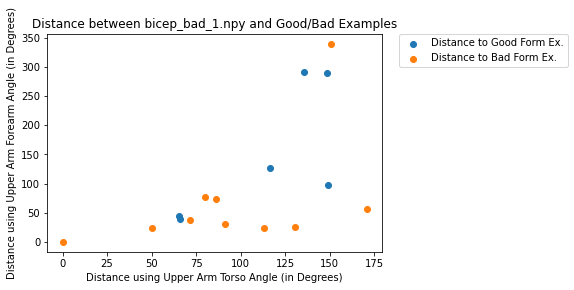

How bad the form is in terms of percentage: -149.16%
-------------------------------------------------------------------------------------------------------------------


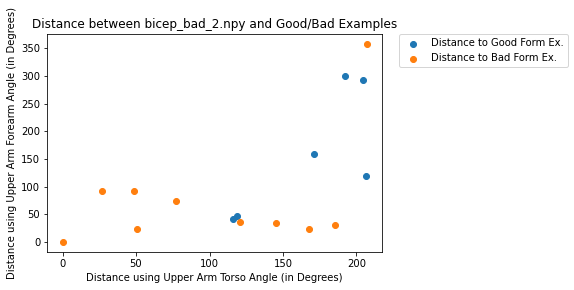

How bad the form is in terms of percentage: -151.48%
-------------------------------------------------------------------------------------------------------------------


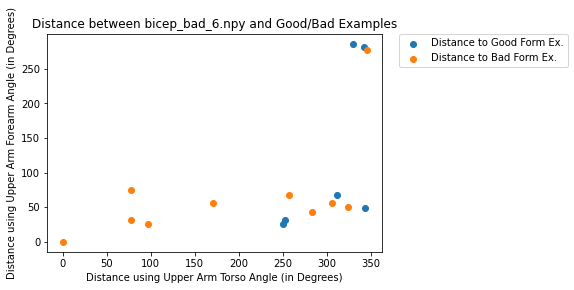

How bad the form is in terms of percentage: -259.68%
-------------------------------------------------------------------------------------------------------------------


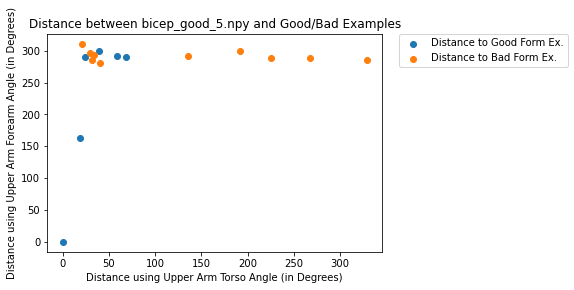

How good the form is in terms of percentage: 49.0%
-------------------------------------------------------------------------------------------------------------------


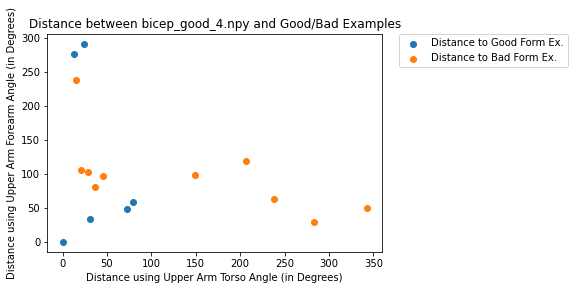

How bad the form is in terms of percentage: -18.13%
-------------------------------------------------------------------------------------------------------------------


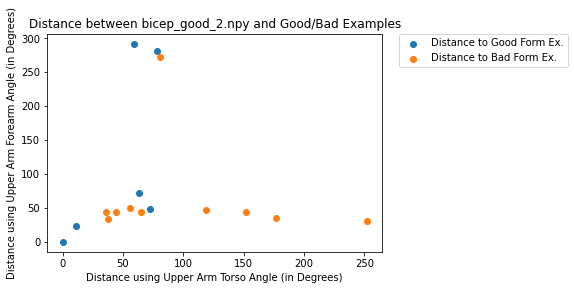

How bad the form is in terms of percentage: -61.0%
-------------------------------------------------------------------------------------------------------------------


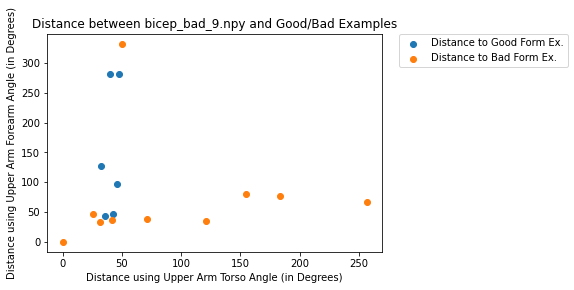

How bad the form is in terms of percentage: -307.39%
-------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

     correct       0.67      1.00      0.80         4
   incorrect       1.00      0.33      0.50         3

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7



In [174]:
_, predictions = Kmeans_test(X_test_names, X_train_1, X_train_2)
print(classification_report(y_test, predictions, target_names=['correct', 'incorrect']))

### Analysis of Angles For Bicep Curls

In [175]:
def plot_angles(names, angle_1, angle_2): 
    for i in range(len(names)): 
        # Generate plots
        # plt.scatter(np.arange(upper_arm_torso_angle.shape[0]),upper_arm_torso_angle, alpha=0.5)
        upper_arm_torso_angle_filtered = np.array(angle_1[i])
        print("Range of Angles between Upper Arm and Torso: {}".format(np.max(upper_arm_torso_angle_filtered)-np.min(upper_arm_torso_angle_filtered)))
        plt.scatter(np.arange(upper_arm_torso_angle_filtered.shape[0]),upper_arm_torso_angle_filtered, c='r', alpha=0.5)
        plt.title(f"Angle between Torso and Upper Arm for {names[i]}")
        plt.xlabel('Frames')
        plt.ylabel('Angle between Torso and Upper Arm')
        # Set range on y-axis so the plots are consistent
        plt.ylim(0,90) 
        plt.show()
        
        upper_forearm_angle_filtered = np.array(angle_2[i])
        print("Minimum Angle between Upper Arm and Forearm: {}".format(np.min(upper_forearm_angle_filtered)))
        plt.scatter(np.arange(upper_forearm_angle_filtered.shape[0]),upper_forearm_angle_filtered, c='b', alpha=0.5)
        plt.title(f"Angle between Upper Arm and Forearm for {names[i]}")
        plt.xlabel('Frames')
        plt.ylabel('Angle between Upper Arm and Forearm')
        # Set range on y-axis so the plots are consistent
        plt.ylim(0,180) 
        plt.show()
        
        print("---------------------------------------------------------------------------------------------------------------")

#### For training data

Range of Angles between Upper Arm and Torso: 17.40037971066917


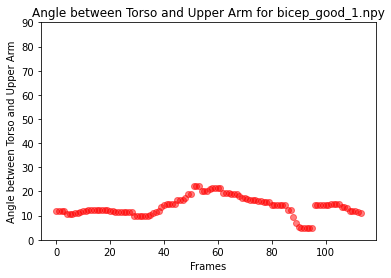

Minimum Angle between Upper Arm and Forearm: 41.13101033726507


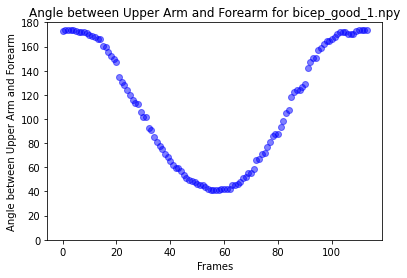

---------------------------------------------------------------------------------------------------------------
Range of Angles between Upper Arm and Torso: 15.792383032870125


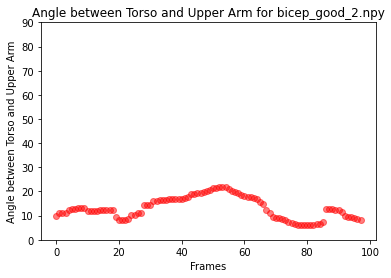

Minimum Angle between Upper Arm and Forearm: 42.244193229928136


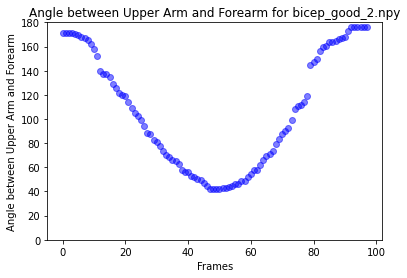

---------------------------------------------------------------------------------------------------------------
Range of Angles between Upper Arm and Torso: 12.87302283231858


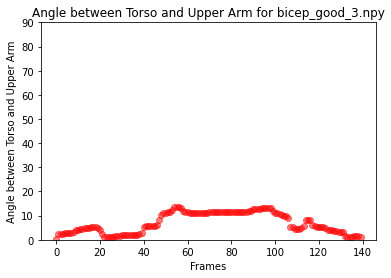

Minimum Angle between Upper Arm and Forearm: 54.80262391551757


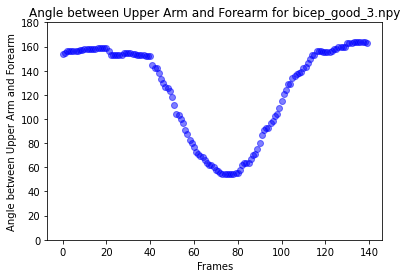

---------------------------------------------------------------------------------------------------------------
Range of Angles between Upper Arm and Torso: 7.358662340516055


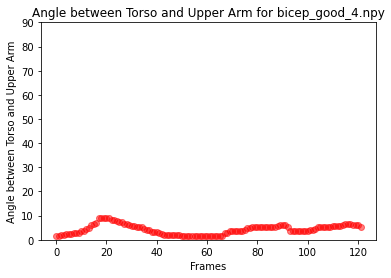

Minimum Angle between Upper Arm and Forearm: 53.08369956946187


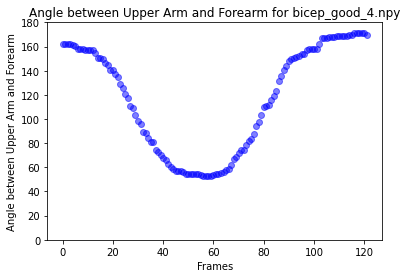

---------------------------------------------------------------------------------------------------------------
Range of Angles between Upper Arm and Torso: 9.576033372232699


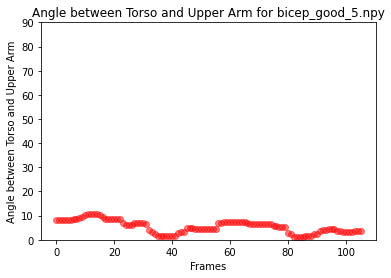

Minimum Angle between Upper Arm and Forearm: 51.43567125569127


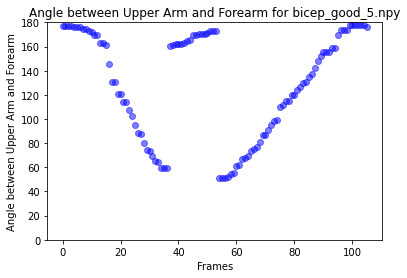

---------------------------------------------------------------------------------------------------------------
Range of Angles between Upper Arm and Torso: 8.812768276441108


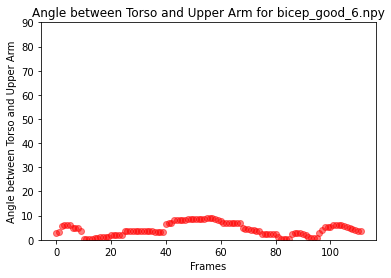

Minimum Angle between Upper Arm and Forearm: 44.96478729823035


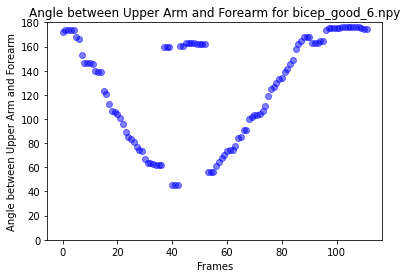

---------------------------------------------------------------------------------------------------------------


In [176]:
# Get a plot for the good form exercises
idx = np.nonzero(np.array(['good' in elem for elem in X_train_names], dtype=int))[0]
X_train_names = np.array(X_train_names)
X_train_1 = np.array(X_train_1, dtype=object)
X_train_2 = np.array(X_train_2, dtype=object)
plot_angles(X_train_names[idx], X_train_1[idx], X_train_2[idx])

#### For Inputted Video

Range of Angles between Upper Arm and Torso: 34.33443396085123


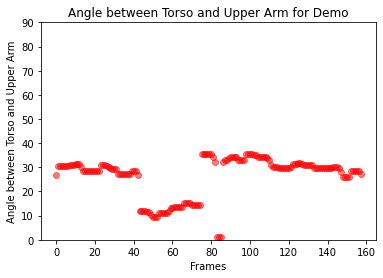

Minimum Angle between Upper Arm and Forearm: 4.549895839415064


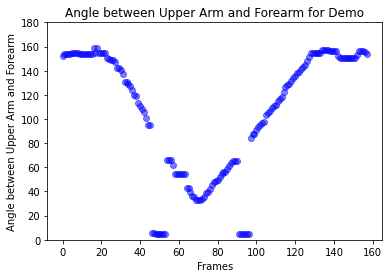

---------------------------------------------------------------------------------------------------------------


In [182]:
plot_angles(['Demo'], inp_seq_1, inp_seq_2)